<a href="https://colab.research.google.com/github/beyzahiz/Transfer-Learning-Fruit-Classification/blob/main/Transfer_Learning_Fruit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -n /content/drive/MyDrive/transfer_learning_fruit_dataset/fruits.zip -d /content/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/transfer_learning_fruit_dataset/fruits.zip


In [39]:
import os
print(os.listdir("/content"))
print(os.listdir("/content/fruits-360_100x100"))

['.config', 'fruits-360_original-size', 'fruits-360_meta', 'fruits-360_3-body-problem', 'drive', 'fruits-360_100x100', 'fruits_small', 'fruits-360_multi', 'test.jpg', 'sample_data']
['fruits-360']


In [40]:
print(os.listdir("/content/fruits-360_100x100"))
print(os.listdir("/content/fruits-360_100x100/fruits-360"))
print(len(os.listdir("/content/fruits-360_100x100/fruits-360/Training")))

['fruits-360']
['Test', 'Training', 'README.md', 'LICENSE']
251


In [41]:
import os

train_path = "/content/fruits-360_100x100/fruits-360/Training"
classes = os.listdir(train_path)

print("Toplam class:", len(classes))
print("İlk 20 class:")
print(classes[:20])

Toplam class: 251
İlk 20 class:
['Apple 8', 'Quince 1', 'Apple 18', 'Banana 3', 'Raspberry 3', 'Cucumber 4', 'Onion Red 3', 'Strawberry 1', 'Blueberry 1', 'Apple Pink Lady 1', 'Grapefruit Pink 1', 'Nut Forest 1', 'Avocado Black 2', 'Mango 1', 'Raspberry 5', 'Pear 10', 'Apple 14', 'Avocado Black 1', 'Tomato 9', 'Pomegranate 1']


In [42]:
import os
import shutil

# Orijinal dataset yolu
base_path = "/content/fruits-360_100x100/fruits-360"
train_path = os.path.join(base_path, "Training")
test_path = os.path.join(base_path, "Test")

# Yeni küçük dataset yolu
small_base = "/content/fruits_small"
small_train = os.path.join(small_base, "Training")
small_test = os.path.join(small_base, "Test")

# Eğer 'fruits_small' klasörü zaten varsa sil
if os.path.exists(small_base):
    shutil.rmtree(small_base)

os.makedirs(small_train, exist_ok=True)
os.makedirs(small_test, exist_ok=True)

# Seçilen 10 class
selected_classes = [
    "Apple Granny Smith 1",
    "Pineapple 1",
    "Raspberry 2",
    "Mandarine 1",
    "Cauliflower 1",
    "Pepper Yellow 1",
    "Pear Williams 1",
    "Cucumber 11",
    "Cherry 5",
    "Nut 4"
]

# Kopyalama işlemi
for cls in selected_classes:
    shutil.copytree(os.path.join(train_path, cls), os.path.join(small_train, cls))
    shutil.copytree(os.path.join(test_path, cls), os.path.join(small_test, cls))

print("Küçük dataset oluşturuldu.")

Küçük dataset oluşturuldu.


In [43]:
print(len(os.listdir("/content/fruits_small/Training")))

10


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/fruits_small/Training"
test_dir = "/content/fruits_small/Test"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [45]:
train_generator = train_datagen.flow_from_directory(  #klasörleri labela çevirir
    train_dir,
    target_size=(224,224), # Updated target_size to 224x224 for ResNet50
    batch_size=32,
    class_mode='categorical'  #one hot encoding
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224), # Updated target_size to 224x224 for ResNet50
    batch_size=32,
    class_mode='categorical'
)

Found 4933 images belonging to 10 classes.
Found 1648 images belonging to 10 classes.


In [46]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    weights='imagenet',  #eğitilmiş veri seti yüklenir
    include_top=False,  #son classification katmanları atılır, boş alan açılır
    input_shape=(224,224,3)
)

In [47]:
base_model.trainable = False
#modeli ilk eğitimle bozmak istenmiyor o yüzden freezing yapılıyor
#küçük dataset ile tüm ağı yeniden eğitmek riskli, sadece üst katmanlar eğitilecek

In [48]:
from tensorflow.keras import layers, models

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 259ms/step - accuracy: 0.9258 - loss: 0.2716 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 1.0000 - loss: 4.1053e-04 - val_accuracy: 1.0000 - val_loss: 7.4692e-04
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 1.0000 - loss: 1.9966e-04 - val_accuracy: 1.0000 - val_loss: 4.7193e-04
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 1.0000 - loss: 1.2179e-04 - val_accuracy: 1.0000 - val_loss: 3.2995e-04
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 1.0000 - loss: 8.1176e-05 - val_accuracy: 1.0000 - val_loss: 2.5597e-04


In [49]:
len(base_model.layers) #kaç layer var

154

In [50]:
#Fine Tuning
# Modelin son katmanlarını açıp tekrardan eğitmek böylece model çok ince detayları daha iyi öğrenmek için güncelleniyor
len(base_model.layers) #kaç layer var

base_model.trainable = True  #bütün katmanlar açılıyor
for layer in base_model.layers[:-20]:  #son 20 katman hariç hepsi yine freezeleniyor
  layer.trainable = False


from tensorflow.keras.optimizers import Adam

model.compile(  #Fine-tuningde büyük learning rate kullanılırsa ImageNet bilgisi bozulur
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3
)

Epoch 1/3
155/155 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.9954 - loss: 0.0443 - val_accuracy: 1.0000 - val_loss: 8.3206e-05
Epoch 2/3
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 4.8390e-05
Epoch 3/3
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 3.5874e-05


In [51]:
#Data Augmentation

train_datagen_aug = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)

train_generator_aug = train_datagen_aug.flow_from_directory(  #bu kuralları klasördeki dosyalara uygular
    train_dir,
    target_size=(224,224), # Updated target_size to 224x224 for ResNet50
    batch_size=32,
    class_mode='categorical'
)

Found 4933 images belonging to 10 classes.


In [52]:
base_model.trainable = False #data augmentation sonrası yeni bilgiler görünce bozulablir model
#o yüzden fine tuning kapattım

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history_aug = model.fit(
    train_generator_aug,
    validation_data = test_generator,
    epochs = 5
)

Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 89s 519ms/step - accuracy: 0.9935 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 1.1140e-05
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 65s 417ms/step - accuracy: 1.0000 - loss: 2.9965e-04 - val_accuracy: 1.0000 - val_loss: 7.4565e-06
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 436ms/step - accuracy: 1.0000 - loss: 1.2454e-04 - val_accuracy: 1.0000 - val_loss: 6.3928e-06
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 65s 422ms/step - accuracy: 0.9999 - loss: 5.2615e-04 - val_accuracy: 1.0000 - val_loss: 2.1005e-04
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 67s 431ms/step - accuracy: 0.9978 - loss: 0.0081 - val_accuracy: 1.0000 - val_loss: 1.1387e-05


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Gerçek class:  Pepper Yellow 1
Tahmin edilen class:  Pepper Yellow 1


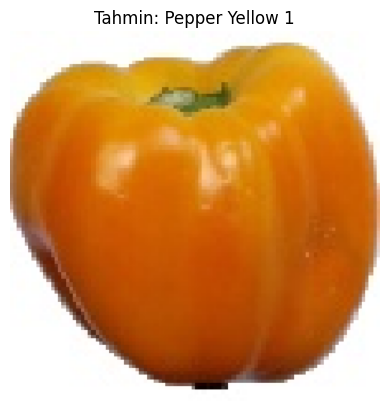

In [53]:
#Test

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

test_dir = "/content/fruits_small/Test"
classes = os.listdir(test_dir)
class_name = random.choice(classes)

#rastgele resim seçme
img_name = random.choice(os.listdir(os.path.join(test_dir, class_name)))
img_path = os.path.join(test_dir, class_name, img_name)

#resmi yükleme
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

#tahmin
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

#class indexi class name e çevirme
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
predicted_class = index_to_class[predicted_class_index]

plt.imshow(img)
plt.title("Tahmin: " + predicted_class)
plt.axis("off")

print("Gerçek class: ", class_name)
print("Tahmin edilen class: ", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tahmin edilen class:  Pineapple 1
Confidence:  0.8645191


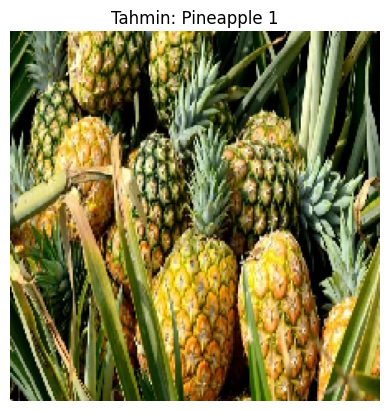

In [54]:
#Distribution Shift
#dataset dışından bir görsel yüklenir böylece model test edilir

from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/test.jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = index_to_class[np.argmax(prediction)]

plt.imshow(img)
plt.title("Tahmin: " + predicted_class)
plt.axis("off")

print("Tahmin edilen class: ", predicted_class)
print("Confidence: ", np.max(prediction)) #softmax çıktısı, olasılık

In [55]:
probs = prediction[0]

for i in range(len(probs)):  #tüm olasılıklar
    print(index_to_class[i], ":", round(probs[i], 3))

Apple Granny Smith 1 : 0.001
Cauliflower 1 : 0.133
Cherry 5 : 0.0
Cucumber 11 : 0.0
Mandarine 1 : 0.001
Nut 4 : 0.0
Pear Williams 1 : 0.001
Pepper Yellow 1 : 0.0
Pineapple 1 : 0.865
Raspberry 2 : 0.0


In [56]:
import numpy as np

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224), # Updated target_size to 224x224 for ResNet50
    batch_size=32,
    class_mode='categorical',
    shuffle=False  #veri sırası sabit kalır, tahmin ve test doğru eşleşir
)
#eğitimde shuffle true iyi, testte shuffle false zorunludur
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

Found 1648 images belonging to 10 classes.
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step


[[164   0   0   0   0   0   0   0   0   0]
 [  0 234   0   0   0   0   0   0   0   0]
 [  0   0 228   0   0   0   0   0   0   0]
 [  0   0   0  78   0   0   0   0   0   0]
 [  0   0   0   0 166   0   0   0   0   0]
 [  0   0   0   0   0  79   0   0   0   0]
 [  0   0   0   0   0   0 166   0   0   0]
 [  0   0   0   0   0   0   0 222   0   0]
 [  0   0   0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0   0   0 145]]


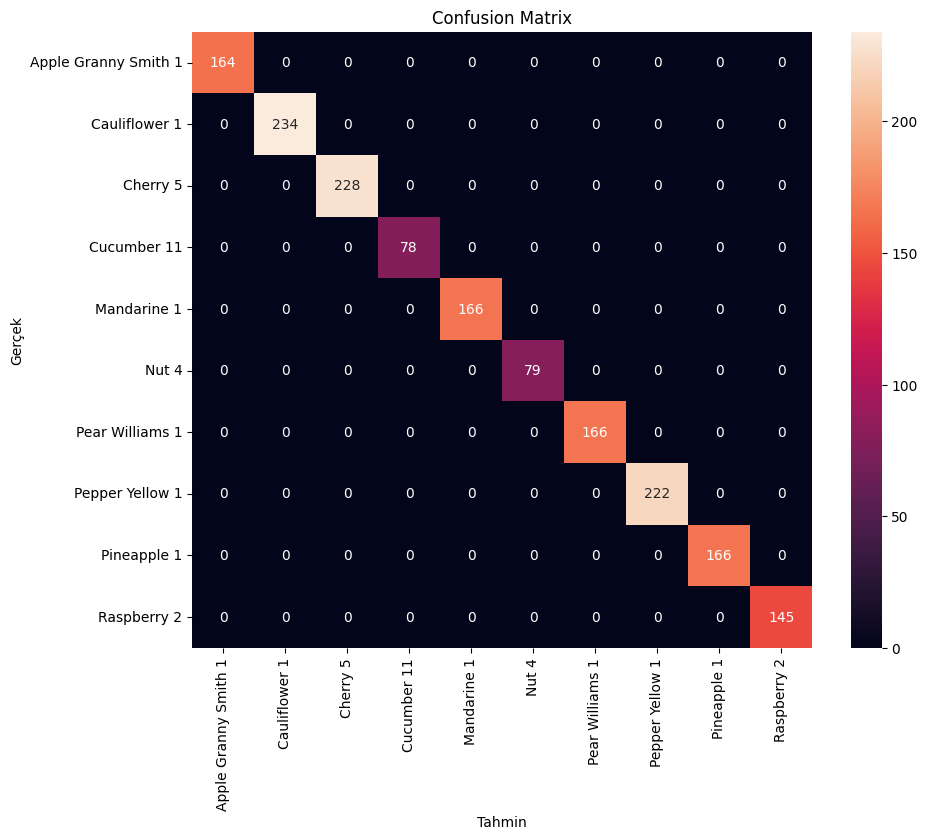

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

In [58]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 1.0


In [60]:
import tensorflow as tf
tf.keras.backend.clear_session() #yeni modele geçmeden önce temizler

#ResNet50 Modeli

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  #İlk aşamada donduruyoruz

model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 sınıf varsa
])

model_resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

history_resnet = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - accuracy: 0.2286 - loss: 2.2136 - val_accuracy: 0.4066 - val_loss: 1.7141
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.5463 - loss: 1.5522 - val_accuracy: 0.7925 - val_loss: 1.2012
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.7403 - loss: 1.0848 - val_accuracy: 0.7888 - val_loss: 0.8593
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8359 - loss: 0.7977 - val_accuracy: 0.8356 - val_loss: 0.6679
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8817 - loss: 0.5978 - val_accuracy: 0.9041 - val_loss: 0.4666
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9102 - loss: 0.4606 - val_accuracy: 0.8999 - val_loss: 0.4080
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9356 - loss: 0.3756 - val_accuracy: 0.9460 - val_loss: 0.3117
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9530 - loss: 0

52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step


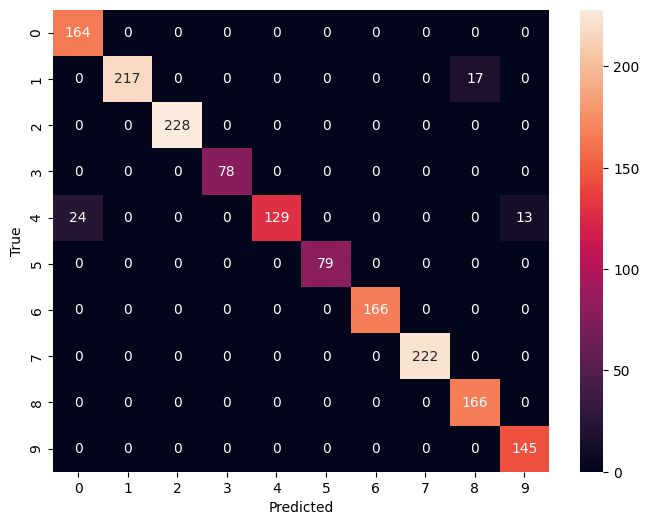

In [63]:
#ResNet50 confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model_resnet.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Gerçek etiketler
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()